# Comparison of different clustering algorithms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_spiral_data, load_aggregation_data, load_birch1_data, load_birch3_data, load_compound_data, load_flame_data, load_pathbased_data, load_sets_data, scale_data, load_fuzzy_data
from timeit import default_timer as timer 
from clustertools.models.distance import KMeans, Regspace
from clustertools.models.similarity import SpectralClustering
from clustertools.models.density import MeanShift, plot_kde, DBSCAN
from clustertools.models.fuzzy import FuzzyCMeans
import pandas as pd
import seaborn as sns
%matplotlib inline


In [2]:
#set font sizes for matplotlib plots and seaborn plots
fontsizeset = 20
rc={'axes.labelsize': fontsizeset, 'font.size': fontsizeset, 'legend.fontsize': fontsizeset, 'axes.titlesize': fontsizeset,'xtick.labelsize': fontsizeset, 'ytick.labelsize': fontsizeset}
sns.mpl.rcParams.update(rc)

In [3]:
#load fuzzy dataset and pre-process
fuzzy = load_fuzzy_data(scale = 'True')
fuzzy = fuzzy[np.arange(0,2309,2),:]

### Mean Shift Algorithm

In [4]:
def plot_mean_shift(data, labels, bandwidth, outliers, save=None): 
 
    f, axarr = plt.subplots(1,3, figsize=(30,10))

    axarr[0].scatter(data[:,0],data[:,1],alpha=.6)
    axarr[0].axis('off')

    axarr[1].scatter(data[:,0],data[:,1],alpha=.6, c = labels, cmap='Set2')
    if outliers >0:
        axarr[1].axis('off')
    else:
        axarr[1].scatter(data[labels==0][:,0],data[labels==0][:,1],s = 100, alpha=.3, marker='*')    
        axarr[1].axis('off')
    
    
    [X, Y, Z] = plot_kde(data[:,0], data[:,1], bandwidth) 
    ma=np.max(np.max(Z)) #max of density
    mi=np.min(np.min(Z)) #min of density
    levels=np.arange(mi,ma+(ma-mi)*0.099,(ma-mi)*0.1) #specify contour levels
    axarr[2].contour(X,Y,Z, levels)
    axarr[2].plot(data[:,0], data[:,1], 'k.', markersize=2, alpha=1)
    axarr[2].axis('off')
    
    axarr[0].set_title('Data points', fontsize=fontsizeset)
    axarr[1].set_title('Clustering', fontsize=fontsizeset)
    axarr[2].set_title('Kernel density estimation', fontsize=fontsizeset)

    if save == None:
        plt.show()
    else: 
        plt.savefig('images/meanshift.png')

116 iterations until termination.
Used bandwidth: 0.250000
Finished after 3.867527422898232
Number of clusters found: 11.000000
There is/are 2.000000 outliers
Max within cluster distance to center: 0.165079
Mean within cluster distance to center: 0.002562
Sum of within cluster squared errors: 0.064314


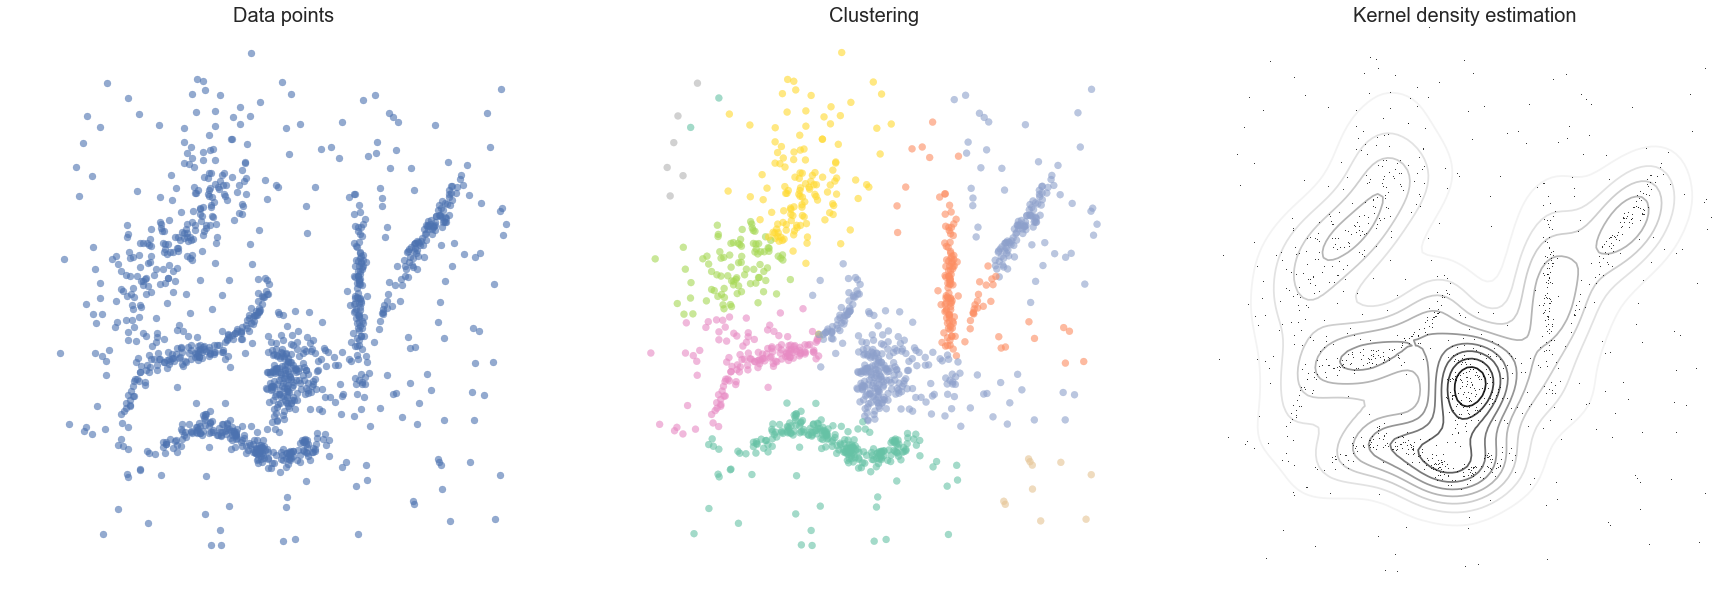

In [5]:
data = fuzzy
bandwidth = 0.25
ms = MeanShift(data, bandwidth)
ms.fit()
labels = ms._cluster_labels
bandwidth = ms._bandwidth   
outliers = ms._outliers 

plot_mean_shift(data, labels, bandwidth, outliers, save=True)

## Fuzzy C Means

In [6]:
def plot_fuzzy_cmeans(data, labels, Uk, c, save=None):
    f, axarr = plt.subplots(1,3, figsize=(30,10))
    axarr[0].scatter(data[:,0],data[:,1],alpha=.6)
    for i in range(c):
        axarr[2].scatter(data[:,0],data[:,1],alpha=.1,s = np.pi * (30 * Uk[i,:])**2)
        axarr[1].scatter(data[np.where( labels==i ),0],data[np.where( labels==i ),1],alpha=.6, cmap='Set2')
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].set_title('Data points', fontsize=fontsizeset)
    axarr[1].set_title('Hard clustering', fontsize=fontsizeset)
    axarr[2].set_title('Fuzzy clustering', fontsize=fontsizeset)
    if save == None:
        plt.show()
    else: 
        plt.savefig('images/fuzzy.png')

Finished after 0.18284776595486107
29 iterations until termination.
Max within cluster distance to center: 2.602749
Mean within cluster distance to center: 0.492092
Sum of within cluster squared errors: 422.068720


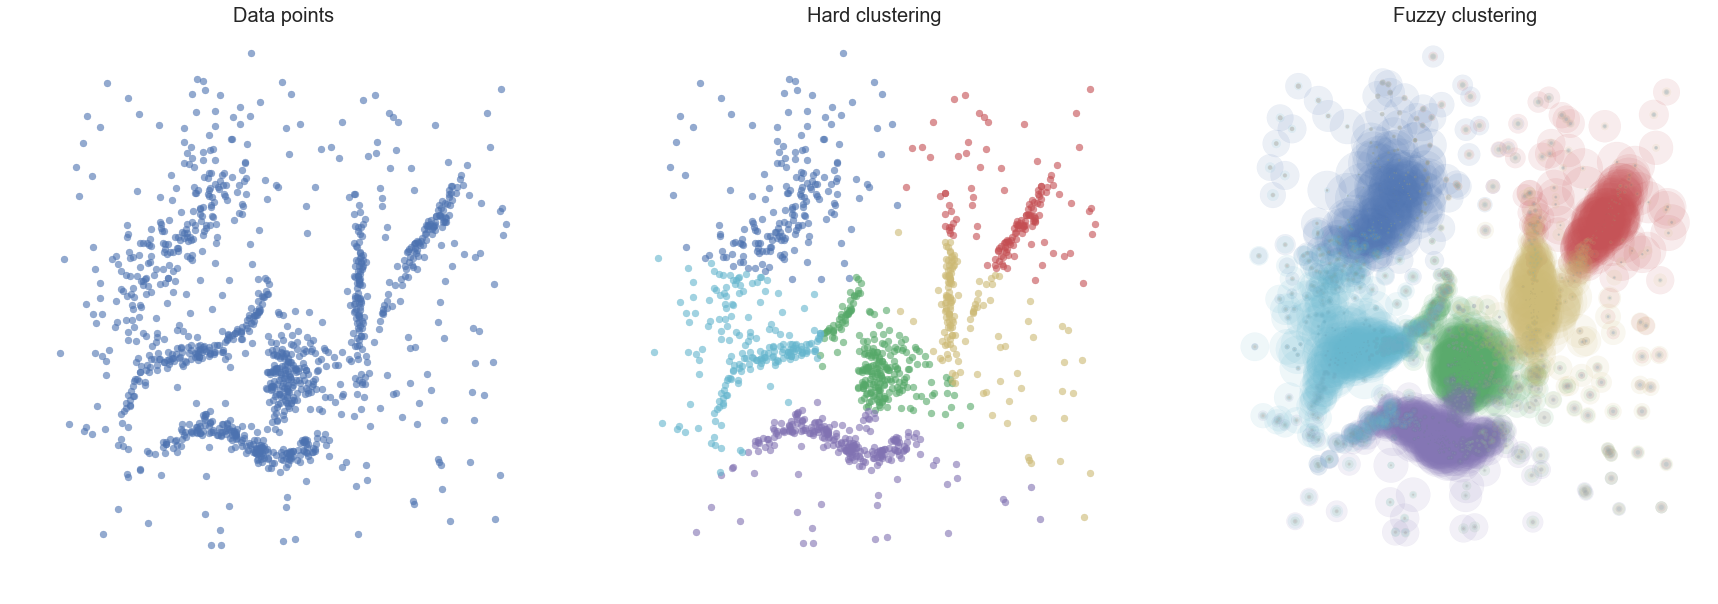

In [7]:
data = fuzzy
c=6
ms = FuzzyCMeans(data,c )
ms.fit()
labels = ms._cluster_labels
Uk = ms._membership 
plot_fuzzy_cmeans(data, labels, Uk, c, save=True)

### Clustering on different data sets

Comment: Ich würde sagen, dass wir tabellen und grafiken (siehe unten) einfach vorbereiten und abspeichern für präsentation und paper, das währrend der präsentation auszurechnen dauert einfach zu lange. 

In [8]:
def format_subplots():
    plt.figure(figsize=(30,8))
    ax1 = plt.subplot2grid((2,5), (0, 0))
    ax2 = plt.subplot2grid((2,5), (0, 1))
    ax3 = plt.subplot2grid((2,5), (0, 2))
    ax4 = plt.subplot2grid((2,5), (0, 3))
    ax5 = plt.subplot2grid((2,5), (0, 4))
    ax6 = plt.subplot2grid((2,5), (1,0), colspan=6)
    ax = [ax1,ax2, ax3, ax4, ax5]
    row_labels=[ 'Computing time [s]', 'iter = # of iterations',  'k = # of clusters', 'Mean cluster-center distance']
    column_labels=['Spiral','Aggregation','Compound', 'Fuzzy', 'Pathbased']
    return ax, row_labels, column_labels

In [9]:
def format_table_data(dataset,estimatecluster, saveas = 'images/tabledataset.png'):
    ax, row_labels, column_labels = format_subplots()
    row_labels = ['       n = # of datapoints', 'd = dimension', 'estimated # of clusters']
    datasetresults = np.zeros((3,np.shape(dataset)[0]))
    for i in range(np.shape(dataset)[0]):
        data = dataset[i]
        datasetresults[ 0,i] = int(np.size(data,0))
        datasetresults[ 1,i] = int(np.size(data,1))
        ax[i].scatter(data[:,0],data[:,1],alpha=.3)
        ax[i].axis('off')
    datasetresults[2,:] = estimatecluster

    df = pd.DataFrame(datasetresults[:,:],row_labels , column_labels)
    ax6 = sns.heatmap(df,vmin=0, vmax=100000, annot=True,cbar = False, fmt="g", linewidths=1, cmap="GnBu",annot_kws={"size": fontsizeset})
    plt.title('Data sets', fontsize=fontsizeset)
    #plt.show()
    plt.savefig(saveas)
    #binary, Blues, BuGn might be other good colormaps to use for table
    

In [10]:
spiral=load_spiral_data(scale = 'True')
aggr=load_aggregation_data(scale = 'True')
compound = load_compound_data(scale = 'True')
fuzzy = load_fuzzy_data(scale = 'True')
fuzzy = fuzzy[np.arange(0,2309,2),:]
pathbased = load_pathbased_data(scale = 'True')
dataset = [spiral, aggr, compound, fuzzy, pathbased]

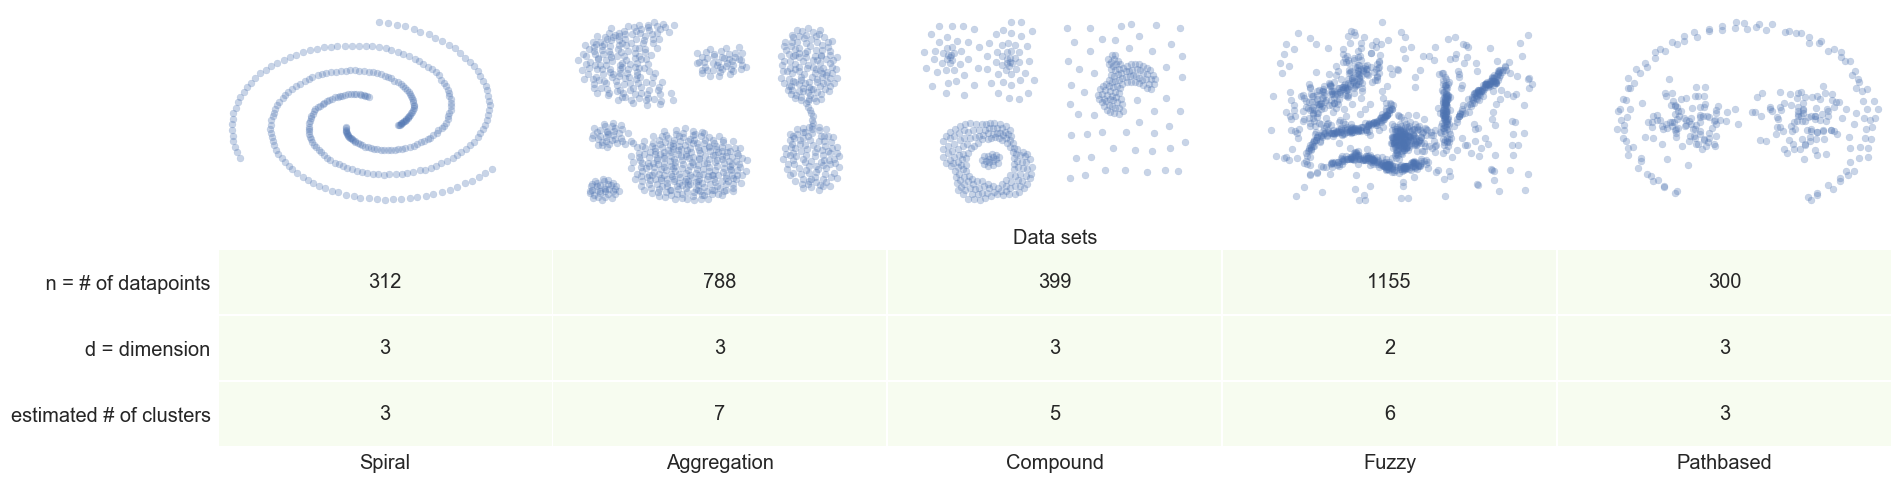

In [11]:
format_table_data(dataset, np.array([3,7,5,6,3]))

Now using the different algorithms on the data sets... still need to specify how (if so) the number of clusters was set and what the maximum number of iterations was. 
Note: some algorithms don't have an iteration count yet and some algorithms don't give cluster centers.

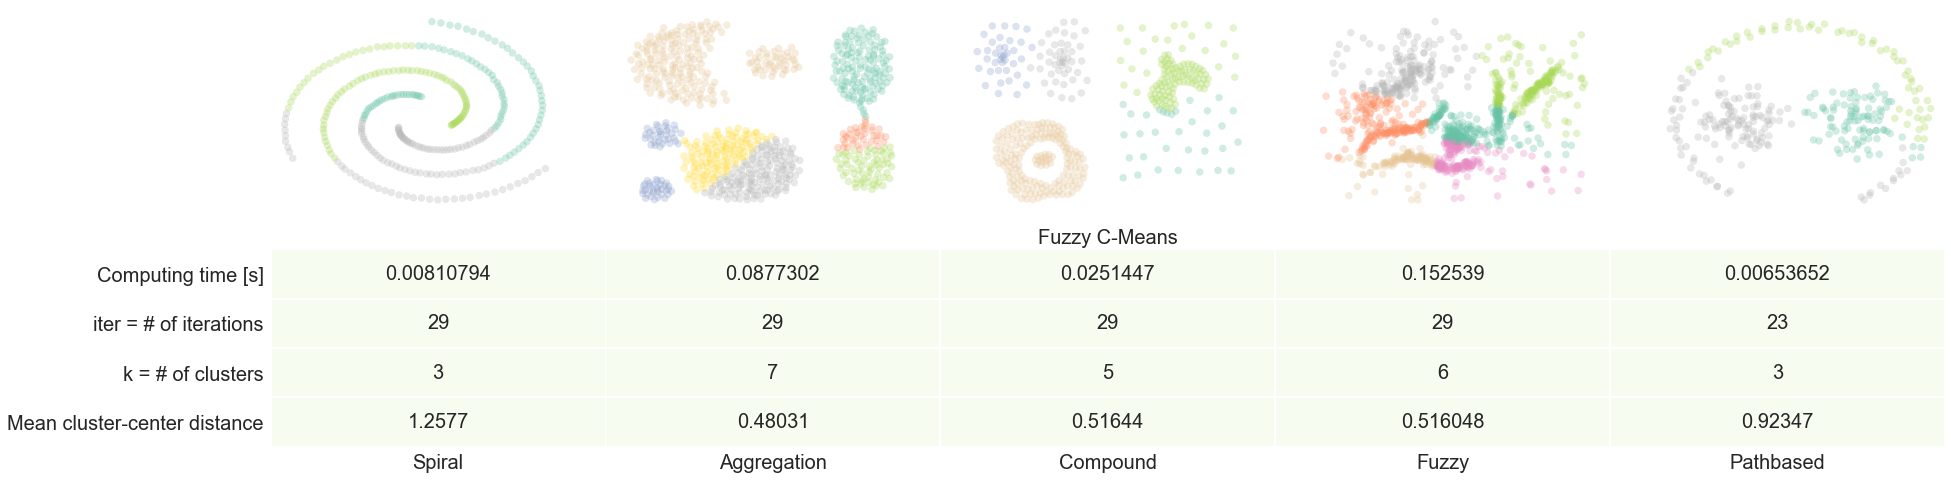

In [18]:
ax, row_labels, column_labels = format_subplots()
clusternumber= [3,7,5,6,3]
results = np.zeros((4,5))
for i in range(5):
    data = dataset[i]
    c=clusternumber[i]
    results[ 2,i] = c
    f = FuzzyCMeans(data,c, verbose = False )
    f.fit()
    labels = f._cluster_labels
    results[ 3,i] = np.mean(f._cluster_dist)
    results[ 0,i] = f._time
    results[ 1,i] = f._iter 
    ax[i].scatter(data[:,0],data[:,1],alpha=.3, c = labels, cmap='Set2')
    ax[i].axis('off')


df = pd.DataFrame(results[:,:], row_labels, column_labels)
ax6 = sns.heatmap(df,vmin=0, vmax=100000, annot=True,cbar = False, fmt="g", linewidths=1, cmap="GnBu")
plt.title('Fuzzy C-Means')
#plt.show()
plt.savefig('images/tablefuzzy.png')

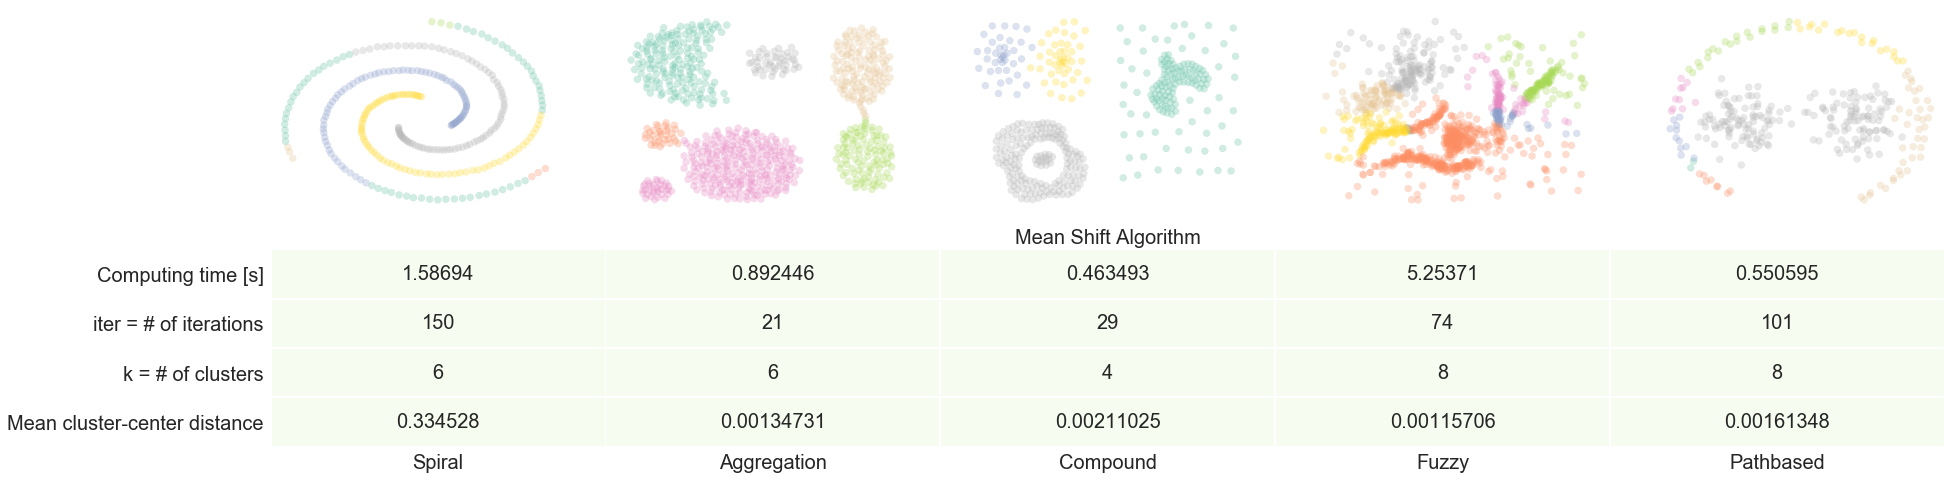

In [19]:
ax, row_labels, column_labels = format_subplots()
results = np.zeros((4,5))
for i in range(5):
    data = dataset[i]
    ms = MeanShift(data, verbose = False)
    ms.fit()
    labels = ms._cluster_labels
    results[3,i] = np.mean(ms._cluster_dist)
    results[0,i] = ms._time
    results[1,i] = ms._iter 
    results[2,i] = max(labels)
    ax[i].scatter(data[:,0],data[:,1],alpha=.3, c = labels, cmap='Set2')
    ax[i].axis('off')

df = pd.DataFrame(results[:,:], row_labels, column_labels)

ax6 = sns.heatmap(df,vmin=0, vmax=100000, annot=True,cbar = False, fmt="g", linewidths=1, cmap="GnBu")

plt.title('Mean Shift Algorithm')
#plt.show()
plt.savefig('images/tablemeanshift.png')

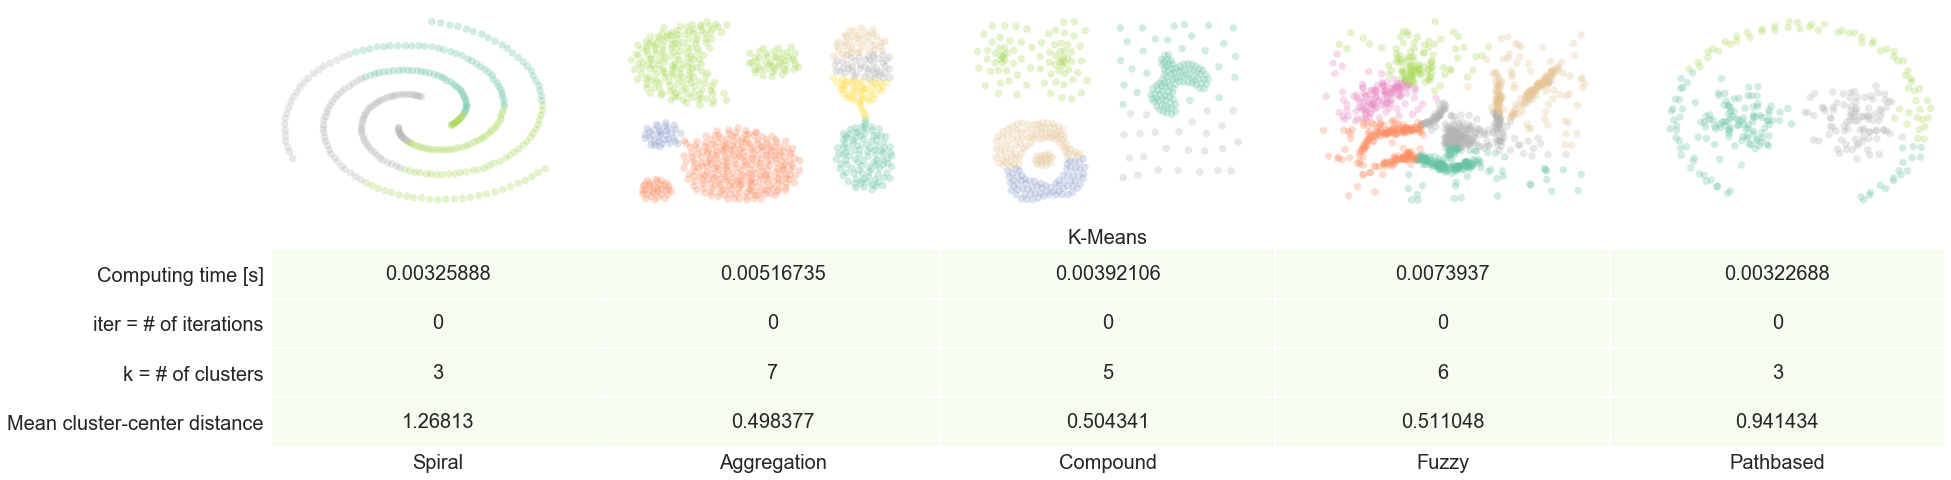

In [20]:
ax, row_labels, column_labels = format_subplots()
clusternumber= [3,7,5,6,3]
results = np.zeros((4,5))
for i in range(5):
    data = dataset[i]
    c=clusternumber[i]
    results[ 2,i] = c
    start_time = timer()
    f = KMeans(data,c, verbose = False )
    f.fit()
    time_taken = timer() - start_time
    labels = f._cluster_labels
    results[ 3,i] = np.mean(f._cluster_dist)
    results[ 0,i] = time_taken
    results[ 1,i] = 0 #f._iter, need to add iteration counter to kmeans code, just set to zero for now
    ax[i].scatter(data[:,0],data[:,1],alpha=.3, c = labels, cmap='Set2')
    ax[i].axis('off')


df = pd.DataFrame(results[:,:], row_labels, column_labels)
ax6 = sns.heatmap(df,vmin=0, vmax=100000, annot=True,cbar = False, fmt="g", linewidths=1, cmap="GnBu")
plt.title('K-Means')
#plt.show()
plt.savefig('images/tablekmeans.png')

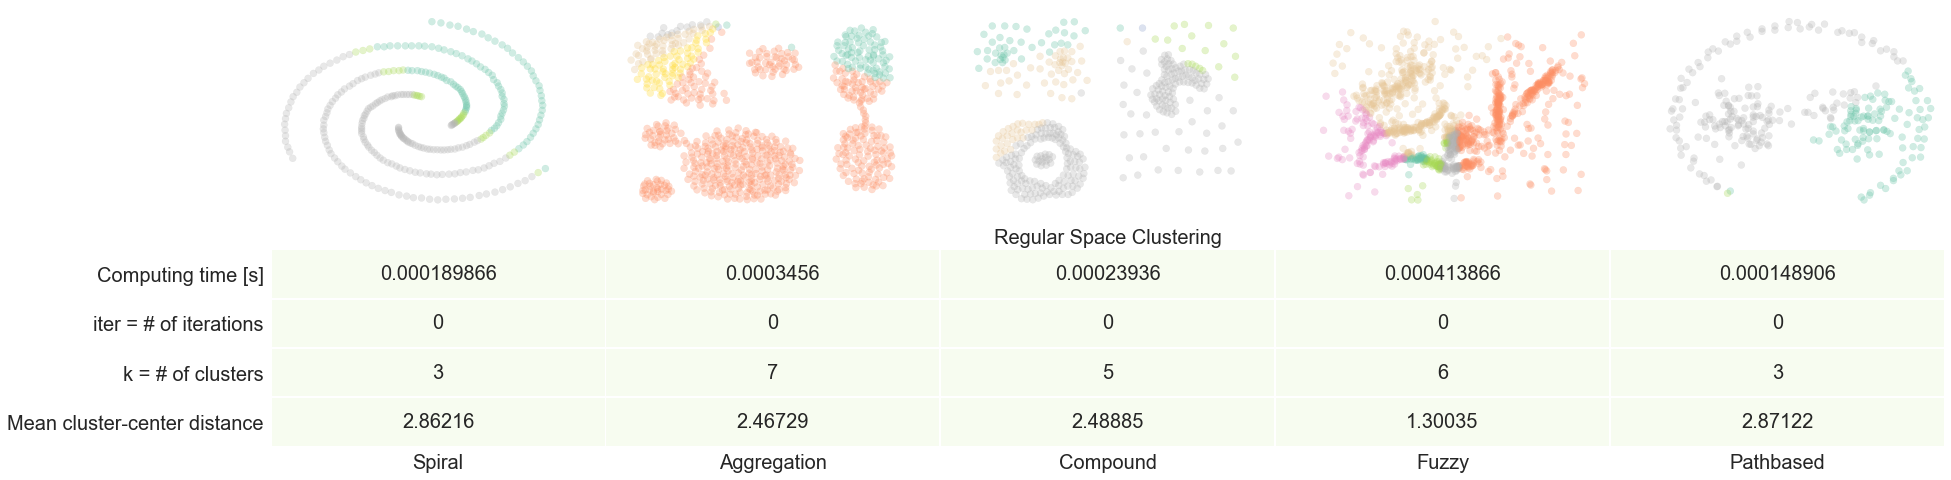

In [17]:
ax, row_labels, column_labels = format_subplots()
clusternumber= [3,7,5,6,3]
results = np.zeros((4,5))
for i in range(5):
    data = dataset[i]
    c=clusternumber[i]
    results[ 2,i] = c
    start_time = timer()
    f = Regspace(data,c,0.05, verbose=False)
    f.fit()
    time_taken = timer() - start_time
    labels = f._cluster_labels
    results[ 3,i] = np.mean(f._cluster_dist)
    results[ 0,i] = time_taken
    results[ 1,i] = 0 #f._iter, need to add iteration counter to kmeans code, just set to zero for now
    ax[i].scatter(data[:,0],data[:,1],alpha=.3, c = labels, cmap='Set2')
    ax[i].axis('off')


df = pd.DataFrame(results[:,:], row_labels, column_labels)
ax6 = sns.heatmap(df,vmin=0, vmax=100000, annot=True,cbar = False, fmt="g", linewidths=1, cmap="GnBu")
plt.title('Regular Space Clustering')
#plt.show()
plt.savefig('images/tableregspace.png')